In [65]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import glob

from astropy import units as u
from astropy import constants as c
from astropy.io import fits

%matplotlib inline

from __future__ import division

In [81]:
sns.color_palette('muted')#.reverse()
sns.set_color_codes('muted')
sns.set_context('talk')
sns.set_style("darkgrid")

# Inspecting the data

###### filename breakdown example: LBL_A30_s0_w035_R_300000

###### Line-by-Line_Airmass 3.0_s0_3.5mm of PWV (precitable water vapor)_R_resolution

###### lam ranges from 0.3 to 30 um (300 - 30000 nm) (~ UVC - microwave)

###### lam in base units of um

In [142]:
hdu_list = fits.open('./data/LBL_A10_s0_w200_R0300000_T.fits')
hdu_data = hdu_list[1].data
hdu_list.close()

## Entire sample spectra

In [147]:
lam   = hdu_data['lam']
trans = hdu_data['trans']

## Section of spectra

#### Using a section of the spectra for now will speed up tests

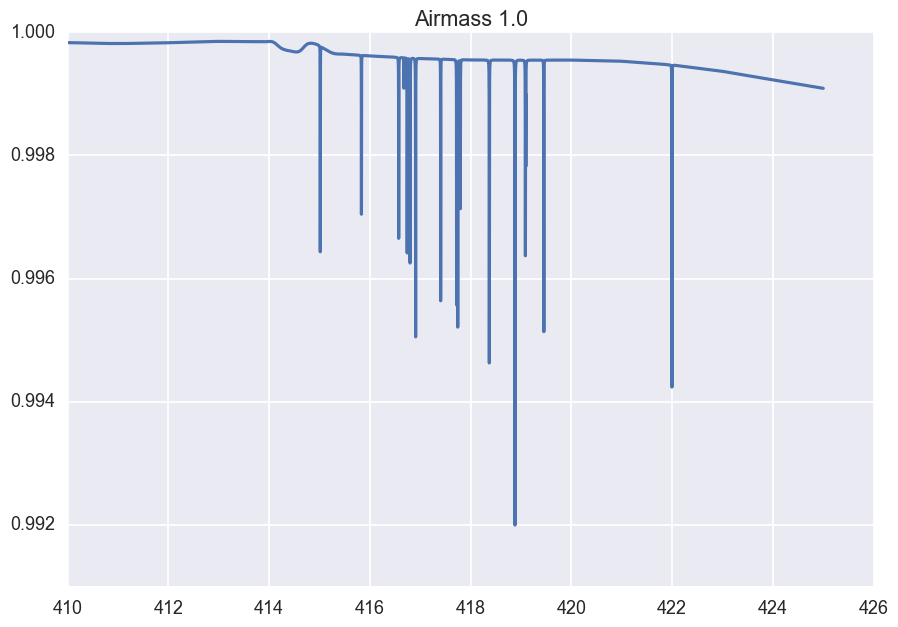

In [63]:
# just using 410 - 420 nanometers for now
lam_bin = lam[(0.41 <= lam) & (lam <= 0.425)]
trans_bin = trans[(0.41 <= lam) & (lam <= 0.425)]
plt.plot(lam_bin*1E3, trans_bin)

plt.title('Airmass 1.0')

# Generalizing to multiple spectra now

## To make a time series, the same library with different airmasses will be used to simulate the amount of water vapor changing with time. 
## The mm of water vapor will remain set at 20 mm for now for each airmass.

In [3]:
pathnames = glob.glob('./data/*')

In [59]:
# Will hold airmass 1.0 ... 3.0
lam_list   = []
trans_list = []

# holds binned values
lam_bin_list   = [] # [am=1.0, am=1.5, ..., am=3.0]
trans_bin_list = []

for i in pathnames:
    hdu_list = fits.open(i)
    hdu_data = hdu_list[1].data
    hdu_list.close()
    
    lam   = hdu_data['lam']
    trans = hdu_data['trans']
    
    lam_list.append(lam)
    trans_list.append(trans)
    
    # just cut out a piece to analyze for now
    lam_bin = lam[(0.41 <= lam) & (lam <= 0.425)]
    trans_bin = trans[(0.41 <= lam) & (lam <= 0.425)] 
    
    lam_bin_list.append(lam_bin)
    trans_bin_list.append(trans_bin)

## Here is what the five different airmasses being used look like relative to each other for this set window

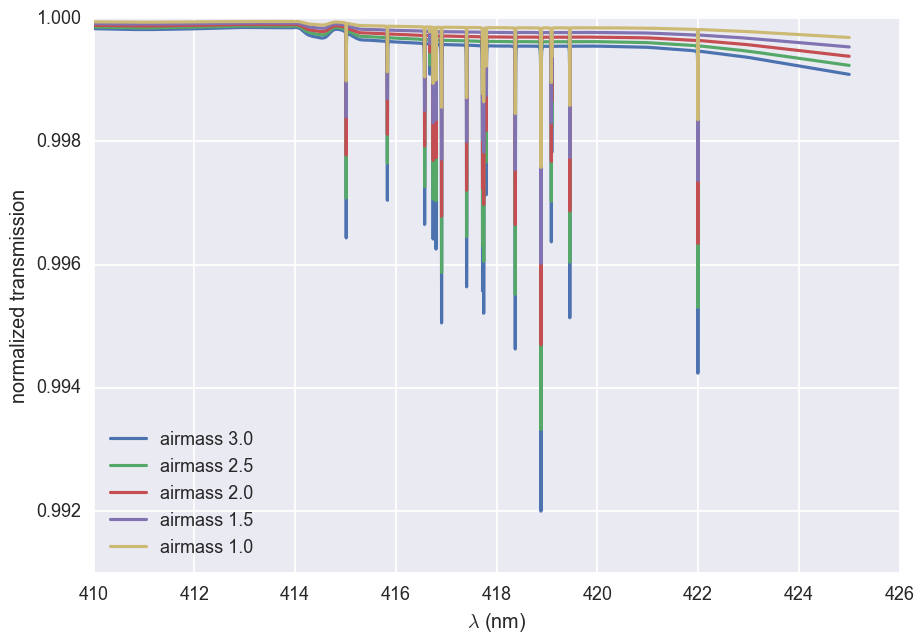

In [60]:
am_list = [1.0, 1.5, 2.0, 2.5, 3.0]
for i,j in enumerate(reversed(am_list)): # to make overlapping easier to see
    i=i+1
    plt.plot(lam_bin_list[-i]*1E3, trans_bin_list[-i], label='airmass %.1f' % j)
    
plt.legend(loc='best')
#plt.ylim(0.998, 1)
#plt.xlim(410, 415)

plt.xlabel(r'$\lambda$ (nm)')
plt.ylabel('normalized transmission')

plt.savefig('./figures/spectra_stack.pdf')

## Next, binnes within this window for one of the airmasses will be setup
## to investigate the stdev and average flux as a function of binsize.
## The left side of the bin will be anchored at 410nm and extended to the right side 

In [77]:
bin_num = 100
bin_intv = ((425 - 410) / bin_num) * u.nm
# holds corresponding binright -> wavelength
wav_list = np.arange(410 + bin_intv.value, 425 + bin_intv.value, bin_intv.value) * u.nm
trans_n = trans_list[0] # will be randomized later

flux_avg_list = []
stdev_list = []
binright = 0
for i in range(bin_num):
    binright += bin_intv
    trans_bin = trans_n[(0.41 <= lam) & (lam <= 0.41 + binright.to('micrometer').value)]
    
    # store stats
    flux_avg_list.append(np.mean(trans_bin))
    stdev_list.append(np.std(trans_bin))

## Average flux vs binsize

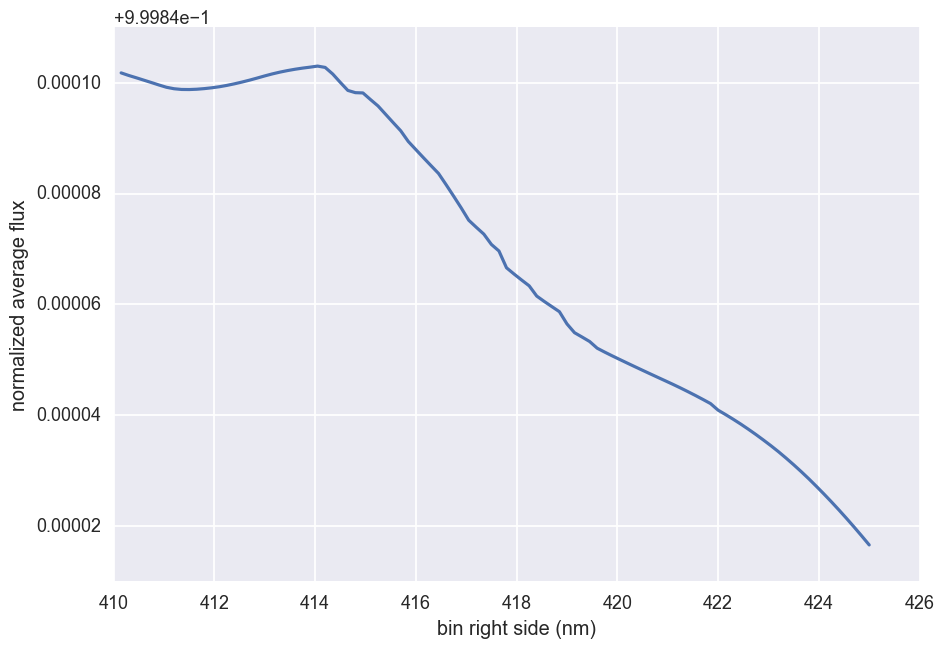

In [86]:
plt.plot(wav_list, flux_avg_list)

plt.xlabel('bin right side (nm)')
plt.ylabel('normalized average flux')

## Flux standard deviation vs binsize

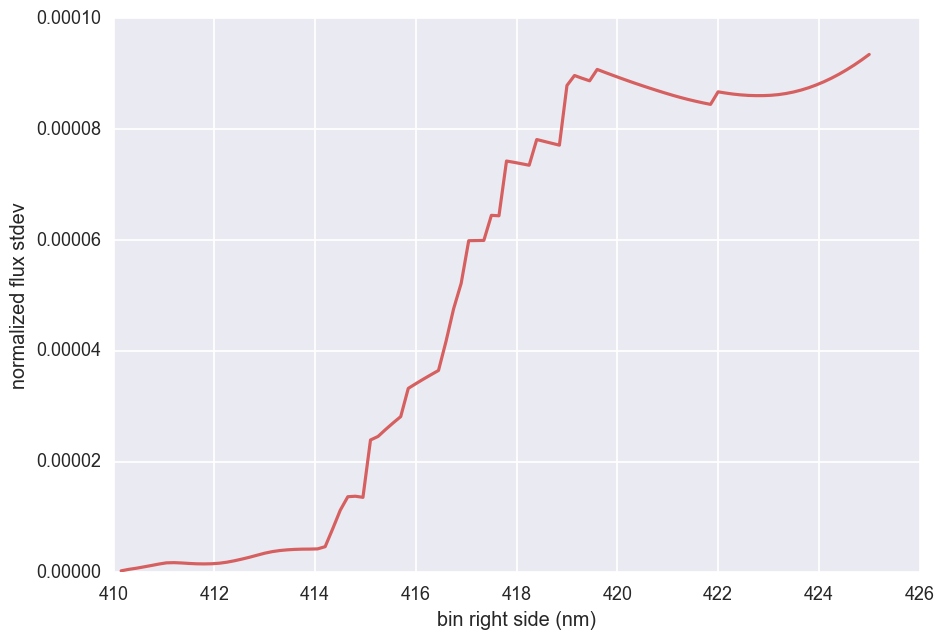

In [90]:
plt.plot(wav_list, stdev_list, 'r-')

plt.xlabel('bin right side (nm)')
plt.ylabel('normalized flux stdev')

## Now, for 50 randomly choses airmasses (times), stdev over time will be plotted for each binsize

In [12]:
import random 

In [148]:
# creat list of random spectra sliced to preset window
N = 50
bin_num = 100
bin_intv = ((425 - 410) / bin_num) * u.nm

trans_time_series = []
for i in range(N):
    trans_n = random.choice(trans_list) # pick random spectra from list of 5 (airmasses)
    trans_bin = trans_n[(0.41 <= lam) & (lam <= 0.425)] # just in window
    trans_time_series.append(trans_bin)

In [172]:
bin_num = 100
bin_intv = ((425 - 410) / bin_num) * u.nm
lam = lam[(0.41 <= lam) & (lam <= 0.425)] # reduce to window

flux_avg_list_binsize = []
stdev_list_binsize = []
binright = 0
for i in range(bin_num):
    flux_avg_list = [] # reset for next binsize
    stdev_list = []
    binright += bin_intv # set current bin
    
    for trans_n in trans_time_series:
        trans_bin = trans_n[(0.41 <= lam) & (lam <= 0.41 + binright.to('micrometer').value)] 
        # store stats over time 
        flux_avg_list.append(np.mean(trans_bin))
        stdev_list.append(np.std(trans_bin))
    
    # store the per time stats, per binsize
    flux_avg_list_binsize.append(flux_avg_list)
    stdev_list_binsize.append(stdev_list)

## Plots

In [ ]:
binsize scale: alpha = 0

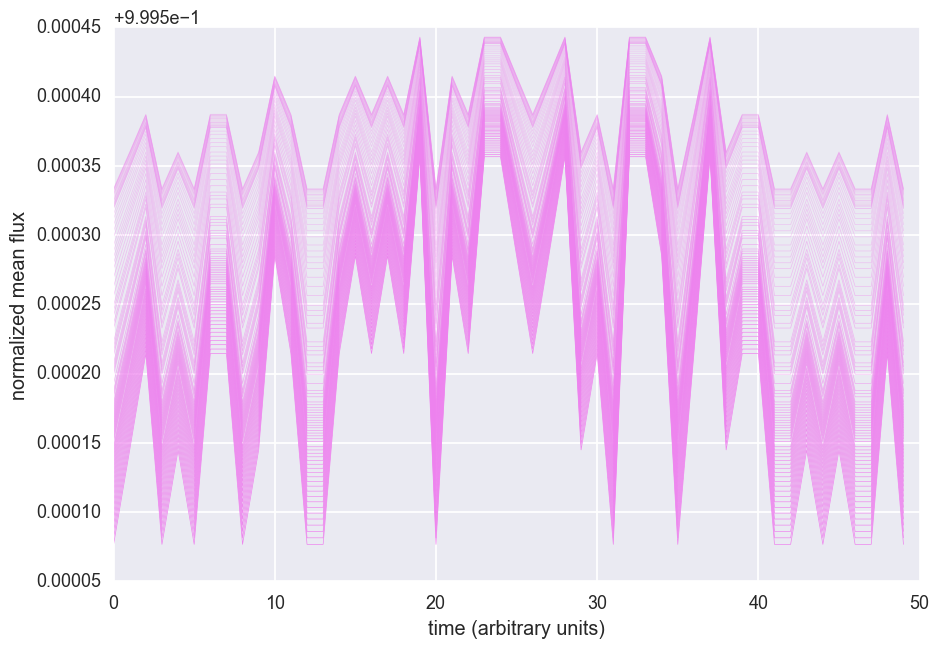

In [223]:
alph = 0
for i in flux_avg_list_binsize:
    plt.plot(i, alpha=alph, c='violet', linewidth=0.5)
    alph += 1 / bin_num

#plt.ylim(1E-6, 10**(-3.5))

plt.xlabel('time (arbitrary units)')
plt.ylabel('normalized mean flux')

plt.savefig('./figures/meanflux_timeseries.pdf')

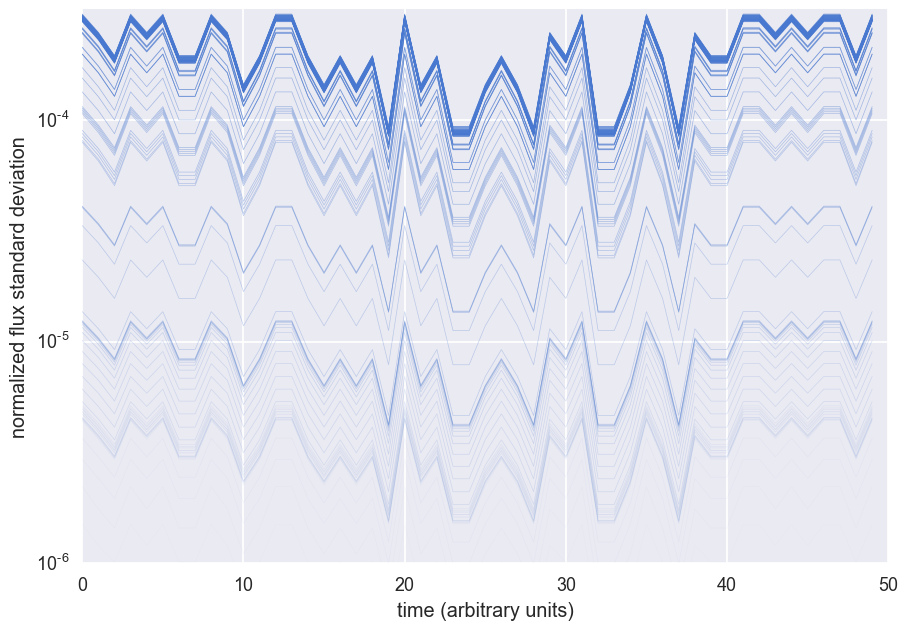

In [224]:
alph = 0
for i in stdev_list_binsize:
    alph += 1 / bin_num
    plt.semilogy(i, alpha=alph, c='b', lw = 0.5)

plt.ylim(1E-6, 10**(-3.5))

plt.xlabel('time (arbitrary units)')
plt.ylabel('normalized flux standard deviation')

plt.savefig('./figures/stdev_timeseries.pdf')